**MNIST:**
- We begin using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by students and employees of the US census bureau. 

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784',as_frame=False)

In [3]:
X,y = mnist.data, mnist.target

In [4]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

Each image has 784 features - because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0 to 255 black. 

In [7]:
import matplotlib.pyplot as plt

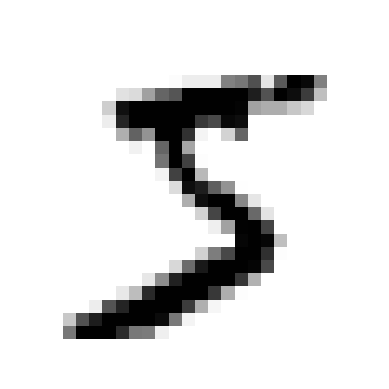

In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
# looks like a 5 - which is later proved right by the labels
y[0]

'5'

**Remember - always have a test set set aside before inspecting the data closely. The MNIST dataset returned by fetch_openml() is actually already split into a training set(first 60,000 images) and a test set (last 10,000) images

In [10]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Training set is already shuffled - good because this guarantees that all cross validation folds will be similar - Shuffling usually only bad for cases say where we've working with time series data.

**Training a Binary Classifier:**
- Simplify the problem now and try to identify one digit - for example, the number 5. 

In [11]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Now - pick a classifier and train it - good starting place is with a stochastic gradient descent classifier using sklearn's SGDClassifier class. 

In [12]:
from sklearn.linear_model import SGDClassifier

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now - use it to detect images of the number 5.

In [14]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
y_test[0]

'7'

In [17]:
X_test[0].shape

(784,)

In [19]:
sgd_clf.predict(X_test[0].reshape(-1,784))

array([False])

**performance measures:**
- Evaluating a classifier => often significantly trickier than evaluating a regressor.
- We look at different performance metrics for evaluating classifiers here:

**Metric Accuracy Using Cross-Validation:**
- Good way to eval a model - use cross validation
- We use the cross_val_score() function to evaluate the SGD Classifier model - using k-fold cross-validation with 3 folds. 
- Remember that k-fold cross validation means splitting the training set into k-folds (3 in this case), then training the model k times - holding out a different fold each time for evaluation. 

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Face value - these seem to look good, but - let's look at a dummy classifier that just classifies every single image in the most frequent class - which is the negative class in this case (non 5s).

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

DummyClassifier()

In [ ]:
print(any(dummy_clf.predict(X_train))) # prints False - no 5s detected

False


In [25]:
# guess the model's accuracy - lets find out
cross_val_score(dummy_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Over 90% accuracy - simply because only about 10% of the images are 5s - so if you always guess an image is not a 5 - you'll be right about 90% of the time. Accuracy - not always the preferred performance measure for classifiers - especially when you're dealing with skewed datasets. Much better way to eval the performance of a classifier is to look at the confusion matrix (CM).

**Implementing Cross Validation:**
- Ocassionally - need more control over the cross validation process than what scikit-learn provides off the shelf. In these cases - you can implement cross validation score yourself. The following code does roughly the same thing as scikit-learn's cross_val_score() function, and it prints the same result. 

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [27]:
skfolds = StratifiedKFold(n_splits = 3) # add shuffle=True, if the dataset is not already shuffled

In [28]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train[train_index]
    y_train_fold = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_fold,y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


**Confusion Matrices:**
- General idea of a confusion matrix - count the number of times instances of class a are classified as class b for all a/b pairs. Confusion matrices - (true labels along the rows), predictions along the columns. 
- To compute the confusion matrix - first - need to have a set of predictions. so that they can be compared to actual targets. You could make predictions on the test set - but its best to keep that untouched for now. 

In [29]:
from sklearn.model_selection import cross_val_predict

In [30]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

The predictions performed by the cross_val_predict function are out of sample predictions.
- Implies that they are predictions on data not seen by the model during its training process. 

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
cm = confusion_matrix(y_train_5, y_train_pred)

In [33]:
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [34]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Confusion matrix - lots of information
- but sometimes => you may prefer a more concise metric
- An interesting one to consider is the accuracy of the positive predictions called the precision of the classifier
  - precision = TP/(TP+FP)
- Used alongside recall - also known as the sensitivity - or the true positive rate (TPR)
  - recall = TP/(TP+FN)

**Precision and Recall:**
- Scikit-learn provides several functions to compute classifier metrics, including precision and recall.

In [35]:
from sklearn.metrics import precision_score, recall_score

In [36]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [37]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

When we claim an image is a 5 (positive) - this is correct only 83.7% of the time. Moreover it only detects 65.1% of the 5s.

Convenient to combine both precision and recall into a single metric called the F1 score - especially when you need a single metric to compare 2 classifiers. F1 score is a harmonic mean of both the precison and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result - a classifier will only get a high F1 score if both recall and precision are high. 

In [38]:
from sklearn.metrics import f1_score

In [39]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

**The Precision/Recall Trade-Off:**

In [40]:
y_scores = sgd_clf.decision_function([some_digit])

In [41]:
y_scores

array([2164.22030239])

All about setting the right threshold.
How do you decide which threshold to use?
- First, use the cross_val_predict() function to get the scores of all instances - returning decision scores not predictions

In [42]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores - use the precision_recall_curve() function to compute precision and recall for all possible thresholds (the function adds a last precision of 1)

In [43]:
from sklearn.metrics import precision_recall_curve

In [44]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Choosing the right threshold:
- Plot of precision and recall v. thresholds - Precision and Recall on the y-axis; thresholds on the x-axis
- Another way - plot precision directly against recall
- np.argmax() - returns the first index of the maximum value
- which in this case would mean the first True value. so for all precisions => compute a precision >= 0.90 then running argmax on this returns the first index corresponding/which satisifies the condition.
- Thereafter - indexing the thresholds array/list to find the corresponding threshold. 
- Make predictions now using this threshold - where by instead of hard predictions - return soft preds and thresholds. 
- Fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold. 

**The ROC Curve:**
- The Receiver Operating Characteristic (ROC) curve is another common tool used with binary classifiers. Very similar to precision/recall curves, but instead of plotting precision v. recall - the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR) - The FPR (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive. The FPR = 1 - true negative rate .

- Once again => there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces 

**One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1 - whereas a purely random classifier will have a ROC AUC equal to 0.5**

So in summary - about training binary classifiers:
- Cross Validation is actually important when evaluating models
- Metrics: Accuracy not a reliable metric for skewed datasets and for binary classification tasks
- How precision, recall and the f1 score are better metrics
- Metrics such as the AUC
- Evaluating performance under different thresholds and choosing the right threshold.
- All this done while considering cross validation

**MultiClass Classification:**
- Whereas binary classifiers distinguish between 2 classes, multiclass classifiers (multinomial classifiers) can distinguish between more than 2 classes
- Some sklearn classifiers e.g Logistic Regression, Random Forest Classifier and GaussianNB are capable of handling multiple classes natively. Others are strictly binary classifiers - e.g SGDClassifier and SVC. 
- For models that do not natively support multiclass classification => you can implement this using an OVR/OVA (one versus rest or one versus all) strategy - where you train a one versus rest classifier for each class in the dataset
- Another strategy - train a binary classifier for every pair of digits: one to distinguish 0s and 1s - another to distinguish 0s and 2s - etc. This is a one-versus-one strategy. 
- Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Try this with the support vector machine classifier

**Error Analysis:**
- Assuming you have found a promising model and want to improve it. One way of doing this is to analyze the types of errors it makes. 
- First, look at the confusion matrix.
- Coloured diagram of the confusion matrix is much easier to analyse. to plot such a diagram, use the confusion matrix display's from_predictions() function like this:

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

**Analysing the confusion matrix often gives you insights into ways to improve your classifier.** 

**Multilabel Classification:**

Each instance - one class.
In some cases - you may want your classifier to output multiple classes for each instance. Consider a FR classifier - what should you do if you recognise several people in the same picture => attach one tag per person it recognises. Classifier with multiple binary tags is called a multilabel classification system. 

In [46]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [47]:
y_train_large = (y_train >= '7')

In [48]:
y_train_odd = (y_train.astype('int8')%2 == 1)

In [49]:
y_multilabel = np.c_[y_train_large, y_train_odd]

In [50]:
y_multilabel.shape

(60000, 2)

In [51]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

**Brief Recap:** The KNN algorithm is a non-parametric, lazy-learning algorithm, meaning it doesn't build a model during training but instead stores the training data and makes predictions at runtime by comparing new data points to the stored data. Its based on the idea that similar instances (based on a distance metric) - are likely to have similar labels. 

- **Steps of the KNN Algorithm:**
    - Store Training Data:
      - KNN Stores the entire training dataset consisting of feature vectors (e.g. numerical or categorical features) and their corresponding labels. (for classiciation) or values (for regression)
    - Choose k:
      - Select the number of neighbors k, to consider, this is a hyperparameter you set (e.g., k=3 means consider the 3 nearest neighbors)
      - Smaller k makes the model sensitive to noise; larger k smooths predictions but may miss local patterns
    - Calculate Distance
      - For a new data point (test instance), compute its distance to all training points using a distance metric, commonly:
        - **Euclidean Distance** => for numerical features
        - **Cosine Distance** => for high dimensional or text data
    - **Identify k Nearest Neighbors:**
        - Sort all training points by distance to the test point and select the k-closest ones
    - **Make a prediction:**
       - for classification => select the most common class among the k-neighbors (majority  vote)

In [53]:
knn_clf.predict([some_digit])

array([[False,  True]])

There's many ways to eval multilabel classifiers 
- could use confusion matrices
- or take averages of things like precision, recall for each label.

**Multioutput Classification:**
- Generalization of multilabel classification where each label can be multiclass (i.e. it can have more than 2 possible values)
- To illustrate => build a system that removes noise from images. Note that the classifier's output is multilabel (one label per pixel), and each label can have multiple values (pixels range from 0 to 255)

In [54]:
np.random.seed(42)

In [55]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

In [56]:
noise = np.random.randint(0, 100, (len(X_test),784))
X_test_mod = X_test + noise

In [57]:
y_train_mod = X_train
y_test_mod = X_test

In [58]:
X_train_mod.shape, y_train_mod.shape

((60000, 784), (60000, 784))

In [59]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [60]:
clean_digit = knn_clf.predict([X_test_mod[0]])

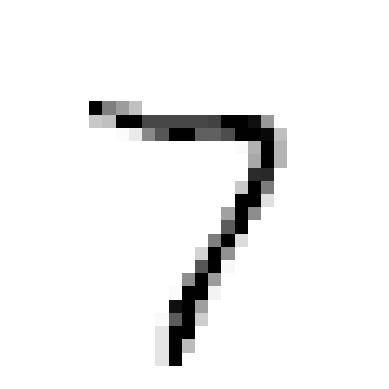

In [61]:
plot_digit(clean_digit)
plt.show()

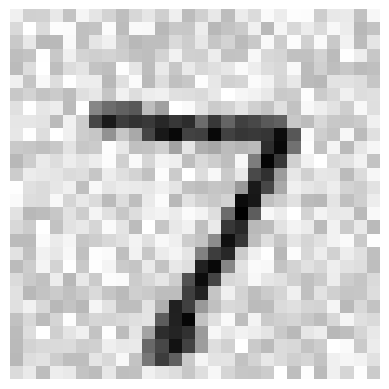

In [62]:
plot_digit(X_test_mod[0])
plt.show()